In [13]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from scipy.signal import convolve
from tqdm import tqdm
import os
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [14]:
import time
start_time = time.time()

In [15]:
# detection parameters
Npix_min = 720
Npix_max = 500*6*6
OW_thr_factor =-0.3

sigma = 15 # smoothing parameter
wx = int(100*6) # rolling window size in x-direction
wy = int(100*6) # rolling window size in y-direction

In [16]:
experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'

In [17]:
datestart, dateend = "2012-01-01", "2012-01-25"
#periods = [
#    ("2012-01-01", "2012-01-25"), ("2012-01-26", "2012-02-19"), ("2012-02-20", "2012-03-15"),
#    ("2012-03-16", "2012-04-09"), ("2012-04-10", "2012-05-04"), ("2012-05-05", "2012-05-29"),
#    ("2012-05-30", "2012-06-28"), ("2012-10-27", "2012-11-20"), ("2012-11-21", "2012-12-15"),
#    
#    ("2012-06-29", "2012-07-28"), ("2012-07-29", "2012-08-27"), ("2012-08-28", "2012-09-26"), ("2012-09-27", "2012-10-26"),
#]

In [18]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': datestart, # time range start
                        'end_time': dateend, # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 0, # minimum longitude of detection region
                        'lon2': 40, # maximum longitude
                        'lat1': -45, # minimum latitude
                        'lat2': -25, # maximum latitude
                        'min_dep': 10, # minimum ocean depth where to look for eddies in m, masking out areas shallower than value
                        'res': 1./60., # resolution of the fields in degree
                        #'OW_thr': data_int,#['OW_std'].values, # 
                        'OW_thr_name': 'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': OW_thr_factor, # Okubo-Weiss parameter threshold
                        'Npix_min': Npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': Npix_max, # maximum number of pixels (grid cells)
                        'no_long': False, # If True, elongated shapes will not be considered
                        'no_two': False # If True, eddies with two minima in the OW
                                        # parameter and a OW > OW_thr in between  will not
                                        # be considered
                       }

In [19]:
if experiment_name.startswith("INALT60"):
    prefix = "2_"
    detection_parameters['res'] = 1./60.
    detection_parameters['lon1'], detection_parameters['lon2'] = 0, 40
    detection_parameters['lat1'], detection_parameters['lat2'] = -45, -25
elif experiment_name.startswith("INALT20"):
    prefix = "1_"
    detection_parameters['res'] = 1./20.
    detection_parameters['lon1'], detection_parameters['lon2'] = -19, 40
    detection_parameters['lat1'], detection_parameters['lat2'] = -49, -7

In [20]:
#depth= 0  #corresponding to... 
#depth_index = 0 

mesh_mask = xr.open_dataset(f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/{prefix}{experiment_name}_mesh_mask.nc') 
indices = np.concatenate((range(0, 11, 10),range(18, 25, 6),range(29, 34, 4),range(36, 40, 3),range(41, 120, 2)))
depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in indices]
print(len(depth_information),depth_information)

48 [(0, 0), (21, 10), (54, 18), (91, 24), (132, 29), (173, 33), (210, 36), (253, 39), (286, 41), (323, 43), (365, 45), (412, 47), (465, 49), (525, 51), (592, 53), (668, 55), (753, 57), (848, 59), (952, 61), (1066, 63), (1189, 65), (1321, 67), (1461, 69), (1608, 71), (1762, 73), (1922, 75), (2086, 77), (2255, 79), (2428, 81), (2603, 83), (2782, 85), (2963, 87), (3146, 89), (3331, 91), (3518, 93), (3706, 95), (3896, 97), (4086, 99), (4279, 101), (4472, 103), (4666, 105), (4861, 107), (5057, 109), (5254, 111), (5452, 113), (5651, 115), (5850, 117), (6050, 119)]


### Detection

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be in the range (-180, 180). `'lon2'` can be smaller than `'lon1'` if you want to extract work in a region extending across the dateline (e.g. `'lon1': 160`, `'lon2': -170`). 
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [22]:
def plot_eddies(data_int, eddies, detection_parameters, datestart, depth):
    """Plot a single time step to see what the detection method detected"""
    t = 0 
    d_p = detection_parameters
    plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.OW.isel(time=t).values,
                   vmin=-1e-9, vmax=1e-9, cmap=cm.balance, shading='auto')
    for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
        plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
                 [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
                 color=c, linestyle=l)
    
    for i in np.arange(0, len(eddies[t])):
        if eddies[t][i]['lon'] < 0:
            eddy_lon = eddies[t][i]['lon'] + 360
        else:
            eddy_lon = eddies[t][i]['lon']
        if eddies[t][i]['type'] == 'cyclonic':
            for s, c in zip([7, 6], ['k', 'gold']):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
        elif eddies[t][i]['type'] == 'anticyclonic':
            for s, c in zip([7, 6], ['k', 'silver']):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

    plt.title(datestart + ' - ' + str(depth) + 'm')
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

> Starting: 20120101, 0m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


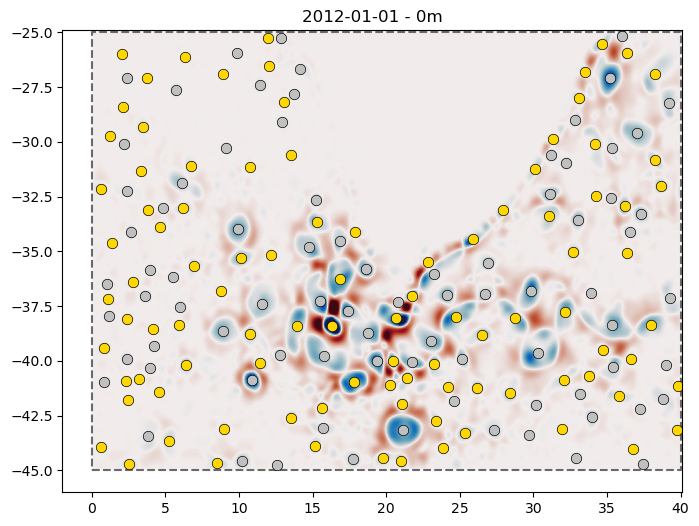

100%|██████████| 2/2 [01:44<00:00, 52.50s/it] 

> Starting: 20120101, 0m ...
Last file (2012-01-25) already exists, skipping...


In [23]:
#for (datestart, dateend) in tqdm(periods):
#    print(f"> Starting: {datestart.replace("-", "")}-{dateend.replace("-", "")} ...")
dates = pd.date_range(start=datestart, end=dateend)
dates_array = dates.to_numpy()
for (depth, depth_index) in tqdm(depth_information):
    print(f"> Starting: {datestart.replace('-', '')}, {depth}m ...")
    outpath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-{depth}/'   ## !! SMOOTHED !!
    if os.path.exists(outpath + f'Eddies_{dateend}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.pickle'):
        print(f'Last file ({dateend}) already exists, skipping...')
        continue
    data_int = xr.open_dataset(outpath + f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}_rolling-{wx}.nc')
    detection_parameters['OW_thr'] = data_int

    # We detect eddies at level XX (as we only calculated the Okubo-Weiss parameter at this level)
    eddies = et.detection.detect_OW(data_int.isel(z=depth_index), detection_parameters, 'OW', 'vort', regrid_avoided=False,     
                                    use_bags=False, use_mp=True,mp_cpu=12)
    
    # Plot
    plot_eddies(data_int, eddies, detection_parameters, datestart,depth)

    # Save
    for i in np.arange(0, len(eddies)):
        if not eddies[i]:
            print(f"No eddies detected for {str(dates_array[i])[0:10]}. Skip ...")
            continue 
        datestring = str(eddies[i][0]['time'])[0:10] #[0:13] YYYY-MM-DDTHH, e.g. 2012-06-30T02 for 2am at 30 June 2012
        with open(outpath + 'Eddies_' + str(datestring) + f'_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()


In [24]:
end_time = time.time()

execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {hours:02}:{minutes:02}:{seconds:02}")

Execution time: 00:01:55
